In [121]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import statistics as st
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.distributions.empirical_distribution import ECDF
from TimeSerie_fct import create_monthly_avg_time_serie
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
import os


data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))

data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.

In [122]:
df = data_temperature.copy()
plt.style.use("ggplot")

In [123]:
# Transformation en moyenne mesuelle
Years = df.Year.unique()
Months = df.Month.unique()
data_M = pd.DataFrame(np.array([[df[(df.Year == y)&(df.Month==m)].TG.mean(),
                        df[(df.Year == y)&(df.Month==m)].TG.median(),df[(df.Year == y)&(df.Month==m)].TG.std()
                                 ,y,int(m)] for y in Years for m in Months]),
                     columns=["Mean","Median","Std","Years","Month"])
data_M = data_M.dropna()

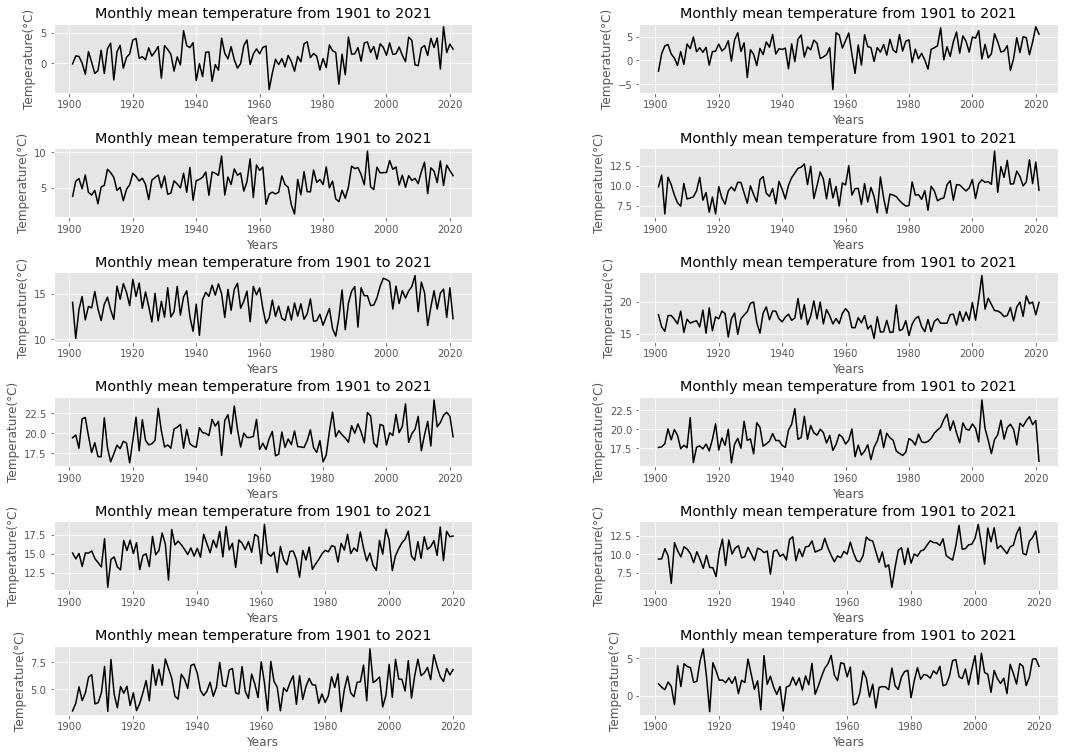

In [64]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10),(ax11,ax12)) = plt.subplots(6,2,figsize=(18,12))
axs = (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12)
for m in Months:
    Y = data_M[data_M.Month == m].Years.unique()
    axs[m-1].plot(Y,data_M[data_M.Month==m].Mean, color = 'k')
    axs[m-1].set_title("Monthly mean temperature from 1901 to 2021")
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

    axs[m-1].set(xlabel="Years",ylabel="Temperature(Â°C)")


plt.savefig("figure/Monthly_mean_median_std.png", dpi=300, bbox_inches='tight')
#plt.close(fig)

(1448,)


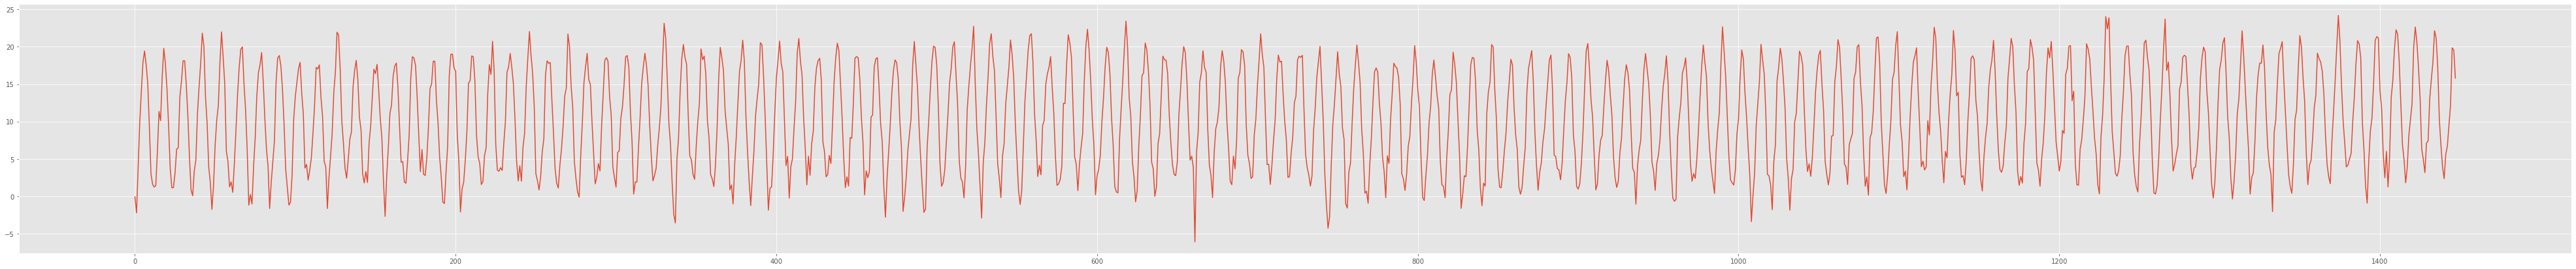

In [9]:
plt.figure(figsize = (70,7))
plt.plot(data_M.Mean)
print(np.shape(data_M.Mean))

In [49]:
n = np.shape(data_M.Mean)[0]
t = np.array(data_M.Mean).reshape((n,1))
one = np.ones(shape=(np.shape(t)[0],1))
d1 = data_M.Month.copy()
d2 = data_M.Years.copy()

D1 = np.array(d1).reshape((n,1))
D2 = np.array(d2).reshape((n,1))
X = np.concatenate([one,D1,D2],axis = 1)


acf = acf(data_M.Mean,nlags=np.shape(data_M.Mean)[0],fft=False)
corr = acf.copy()
print(corr)
sigma = data_M.Mean.var()*sc.linalg.toeplitz(corr)
reg = sm.OLS(data_M.Mean,X).fit()

[ 1.00000000e+00  8.27812479e-01  4.75990202e-01 ... -3.85515458e-03
 -2.54014799e-03 -8.81034349e-04]


In [52]:
print(reg.summary())
coef = reg.params

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     37.11
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           1.92e-16
Time:                        15:58:01   Log-Likelihood:                -4774.5
No. Observations:                1448   AIC:                             9555.
Df Residuals:                    1445   BIC:                             9571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.9981      9.698     -1.650      0.0

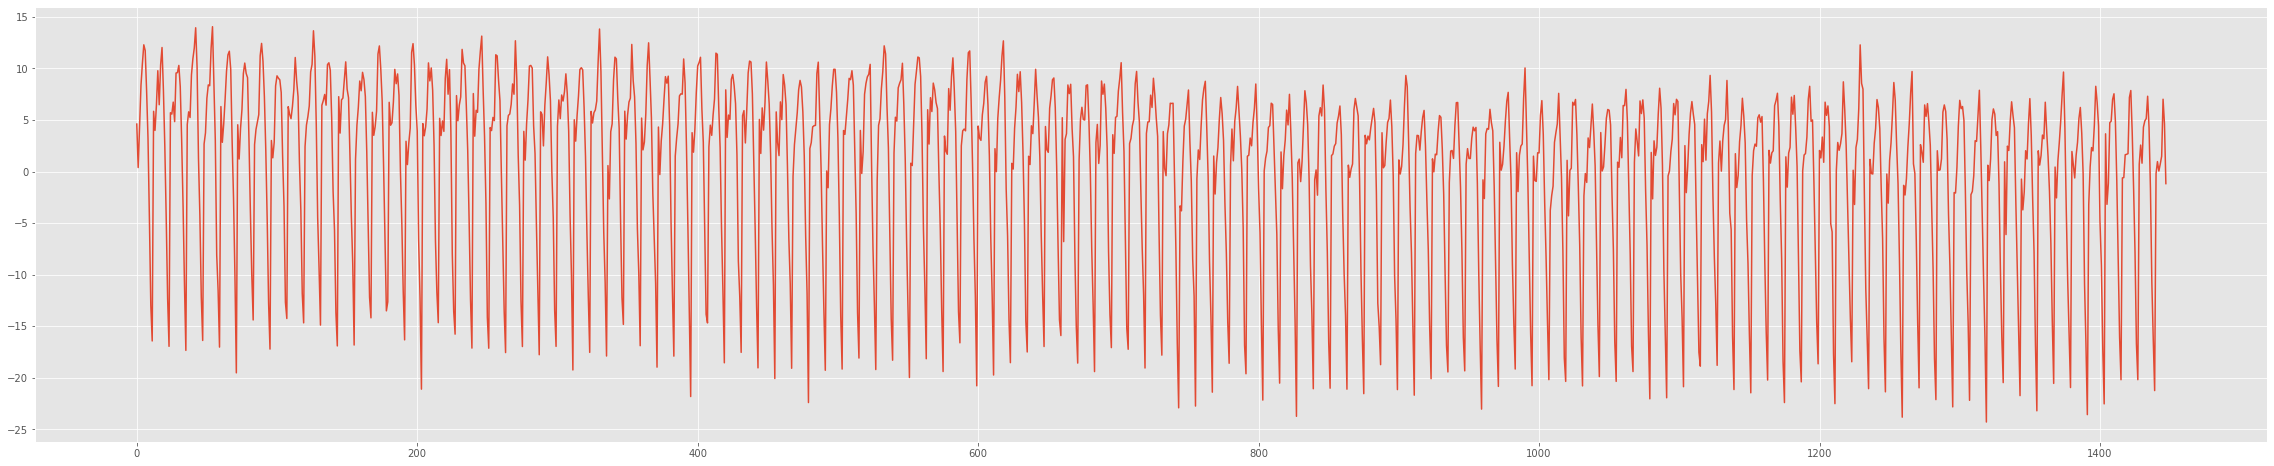

In [61]:
f = lambda x,t: coef[0]+coef[1]*x+ coef[2]*t
t = np.arange(np.shape(d1)[0])
plt.figure(figsize = (40,8))

r = f(d1,d2)
m = r.mean()

#plt.plot(t,m +5*(r-m))
plt.plot(data_M.Mean-(m +5*(r-m)))

In [128]:
n = np.shape(data_M.Mean)[0]
t = np.array(data_M.Mean).reshape((n,1))
one = np.ones(shape=(np.shape(t)[0],1))
d = np.concatenate([np.array([(data_M.Month == float(i))]).reshape((n,1)) for i in np.arange(1,13)],axis = 1)
d2 = data_M.Years.copy()

#D1 = np.array(d).reshape((n,12))
D2 = np.array(d2).reshape((n,1))
X = np.concatenate([d,D2],axis = 1)

print(data_M.Mean)

acf_ = acf(np.array(data_M.Mean),nlags=n,fft=False)

sigma = data_M.Mean.var()*sc.linalg.toeplitz(acf_)
reg = sm.OLS(data_M.Mean,X).fit()

0       -0.087097
1       -2.239286
2        3.812903
3        9.870000
4       14.041935
          ...    
1443     9.443333
1444    12.261290
1445    19.856667
1446    19.551613
1447    15.800000
Name: Mean, Length: 1448, dtype: float64


In [130]:
print(reg.summary())
coef = reg.params

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1934.
Date:                Wed, 03 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:46:45   Log-Likelihood:                -2752.2
No. Observations:                1448   AIC:                             5530.
Df Residuals:                    1435   BIC:                             5599.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -21.3483      2.410     -8.857      0.0

In [132]:
def ff(m,y):
    tg = 0
    for i in range(1,13):
        tg += (m==float(i))*coef[i-1]
    tg += coef[-1]*y
    return tg

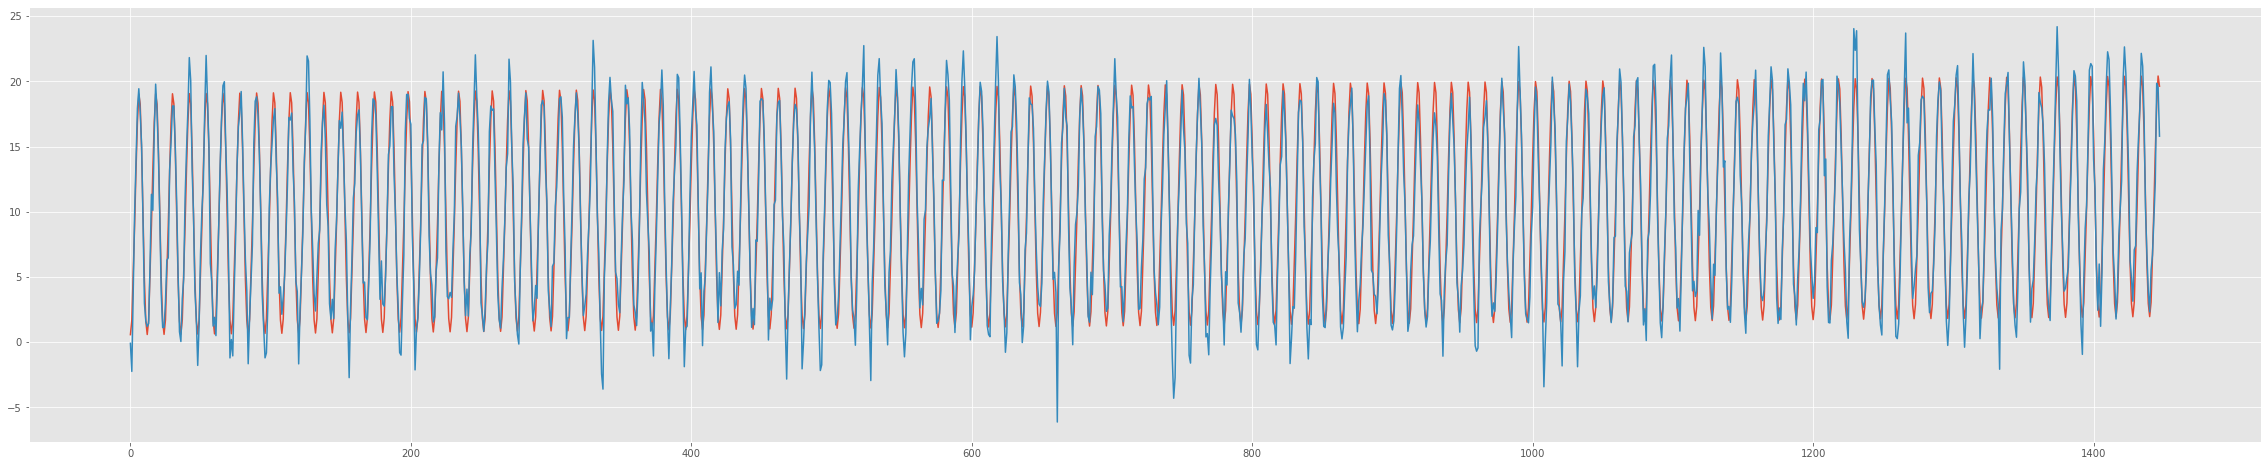

In [139]:
plt.figure(figsize=(40,8))
t = np.arange(np.shape(d1)[0])
plt.plot(t,ff(data_M.Month,data_M.Years))
plt.plot(data_M.Mean)